## Image Segmentation

In [3]:
pip install 'setuptools<69.0.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.8.0
    Uninstalling setuptools-75.8.0:
      Successfully uninstalled setuptools-75.8.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
# utils package installation
!pip install rembg
!pip install trimesh
!pip install onnxruntime
!pip install utils
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-6dcyxpr9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-6dcyxpr9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [3]:
# !pip install torchvision
from utils.sam_utils import sam_init, sam_out_nosave
from utils.utils import pred_bbox, image_preprocess_nosave
import torch

def preprocess(predictor, raw_im, lower_contrast=False):
    raw_im.thumbnail([512, 512], Image.Resampling.LANCZOS)
    image_sam = sam_out_nosave(predictor, raw_im.convert("RGB"), pred_bbox(raw_im))
    input_256 = image_preprocess_nosave(image_sam, lower_contrast=lower_contrast, rescale=True)
    torch.cuda.empty_cache()
    return input_256

In [7]:
!pip install pillow-heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.5 MB/s eta 0:00:00


In [ ]:
import os
from pillow_heif import register_heif_opener
from PIL import Image

# Register HEIC opener
register_heif_opener()

# Define your root directory and subfolders
root_dir = "clothes/test" 
folders = ['pants', 'shirts', 'shorts', 't-shirts']

for folder in folders:
    folder_path = os.path.join(root_dir, folder)
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.heic'):
            heic_file = os.path.join(folder_path, filename)
            jpg_file = os.path.join(folder_path, filename.rsplit('.', 1)[0] + '.jpg')

            # Open and convert the image
            try:
                img = Image.open(heic_file)
                img.save(jpg_file, "JPEG")
                print(f"Converted: {filename} -> {os.path.basename(jpg_file)}")
            except Exception as e:
                print(f"Failed to convert {filename}: {e}")


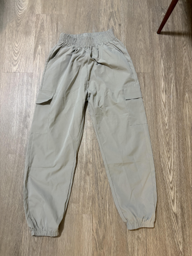

In [5]:
from PIL import Image
import os

_GPU_INDEX = 0

example_input_path = "./clothes/test/pants/01_pants.jpg"
example_dir = ".clothes/test/pants"

os.makedirs(example_dir, exist_ok=True)
input_raw = Image.open(example_input_path)

# show the input image
input_raw_copy = input_raw.copy()
input_raw_copy.thumbnail((256, 256))
input_raw_copy

In [6]:
# initialize the Segment Anything model
predictor = sam_init(_GPU_INDEX)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MDI_project/sam_vit_h_4b8939.pth'

In [ ]:
# preprocess the input image
input_256 = preprocess(predictor, input_raw)
input_256

In [ ]:
# from PIL import Image

# image_path = "clothes/pants/test/01_pants.jpg"
# input_256.save(image_path)

In [ ]:
import os
import torch

# GPU Index (Set to 0 if using CUDA, otherwise it'll default to CPU)
_GPU_INDEX = 0

# Root directory for dataset
root_dir = "./clothes/test"
categories = ["pants", "shirts", "shorts", "t-shirts"]

# Initialize the Segment Anything Model (SAM)
predictor = sam_init(_GPU_INDEX)

def preprocess(predictor, raw_im, lower_contrast=False):
    """Preprocess image using SAM."""
    raw_im.thumbnail([512, 512], Image.Resampling.LANCZOS)
    image_sam = sam_out_nosave(predictor, raw_im.convert("RGB"), pred_bbox(raw_im))
    input_256 = image_preprocess_nosave(image_sam, lower_contrast=lower_contrast, rescale=True)
    torch.cuda.empty_cache()
    return input_256

# Iterate through each category (pants, shirt, shorts, t-shirt)
for category in categories:
    input_folder = os.path.join(root_dir, category)
    output_folder = os.path.join(root_dir, f"{category}_segmented")

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Process all images in the folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Open and process the image
            input_raw = Image.open(image_path)
            processed_image = preprocess(predictor, input_raw)

            # Save processed image
            processed_image.save(output_path)
            print(f"Saved: {output_path}")

print("All images processed and saved!")

## Create the Metadata

In [ ]:
import os
import json
import cv2
import numpy as np
from sklearn.cluster import KMeans

# Function to get dominant colors
def get_dominant_colors(image_path, k=3):
    """Extracts the top k dominant colors from an image using KMeans clustering."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (100, 100))  # Resize for efficiency
    pixels = image.reshape(-1, 3)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pixels)

    # Get the k dominant colors
    return [get_color_name(color) for color in kmeans.cluster_centers_]

# Function to match RGB to closest known color
def get_color_name(rgb):
    """Maps an RGB value to a general color name."""
    colors = {
        "black": (0, 0, 0), "white": (255, 255, 255), "red": (255, 0, 0),
        "blue": (0, 0, 255), "green": (0, 255, 0), "yellow": (255, 255, 0),
        "purple": (128, 0, 128), "orange": (255, 165, 0), "gray": (128, 128, 128),
        "pink": (255, 192, 203), "brown": (165, 42, 42)
    }
    return min(colors.keys(), key=lambda c: np.linalg.norm(np.array(colors[c]) - np.array(rgb)))

# Root directory where segmented images are stored
root_dir = "./clothes/train"
# categories = ["pants_segmented", "shirt_segmented", "shorts_segmented", "t-shirt_segmented"]
categories = ["shirt_segmented", "t-shirt_segmented"]

# Create a dictionary to store metadata
metadata = {}

# Process each segmented folder
for category in categories:
    category_name = category.replace("_segmented", "")  # Remove _segmented suffix
    folder_path = os.path.join(root_dir, category)

    metadata[category_name] = []
    for filename in os.listdir(folder_path):
        if filename.endswith((".jpg", ".png")):
            image_path = os.path.join(folder_path, filename)

            # Get dominant colors
            dominant_colors = get_dominant_colors(image_path)

            # Assign gender
            gender = ["men", "women"]

            # Append metadata entry
            metadata[category_name].append({
                "filename": filename,
                "category": category_name,
                "color": dominant_colors,
                "style": ["casual"],
                "gender": gender
            })

# Save metadata to JSON file
json_path = os.path.join(root_dir, "metadata.json")
with open(json_path, "w") as f:
    json.dump(metadata, f, indent=4)

print(f"Metadata saved to {json_path}")
